Results for dataset without categorical columns:
Random Forest - MSE: 13802440029.124859, R2: 0.831056676787034
XGBoost - MSE: 14226812718.19437, R2: 0.8258623102677127
Gradient Boosting - MSE: 14054715308.76158, R2: 0.8279688007291505
CatBoost - MSE: 11974751783.204039, R2: 0.8534277738837491

Results for dataset without main columns:
Random Forest - MSE: 13753662022.594166, R2: 0.8316537247369334
XGBoost - MSE: 14421761143.146856, R2: 0.8234761209637123
Gradient Boosting - MSE: 13642081091.873951, R2: 0.8330194871096219
CatBoost - MSE: 11729097428.291044, R2: 0.8564346091239795


C:\Users\jos_m\AppData\Local\Temp\ipykernel_15900\1189315549.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='MSE', hue='Dataset', data=results_df, ci=None)


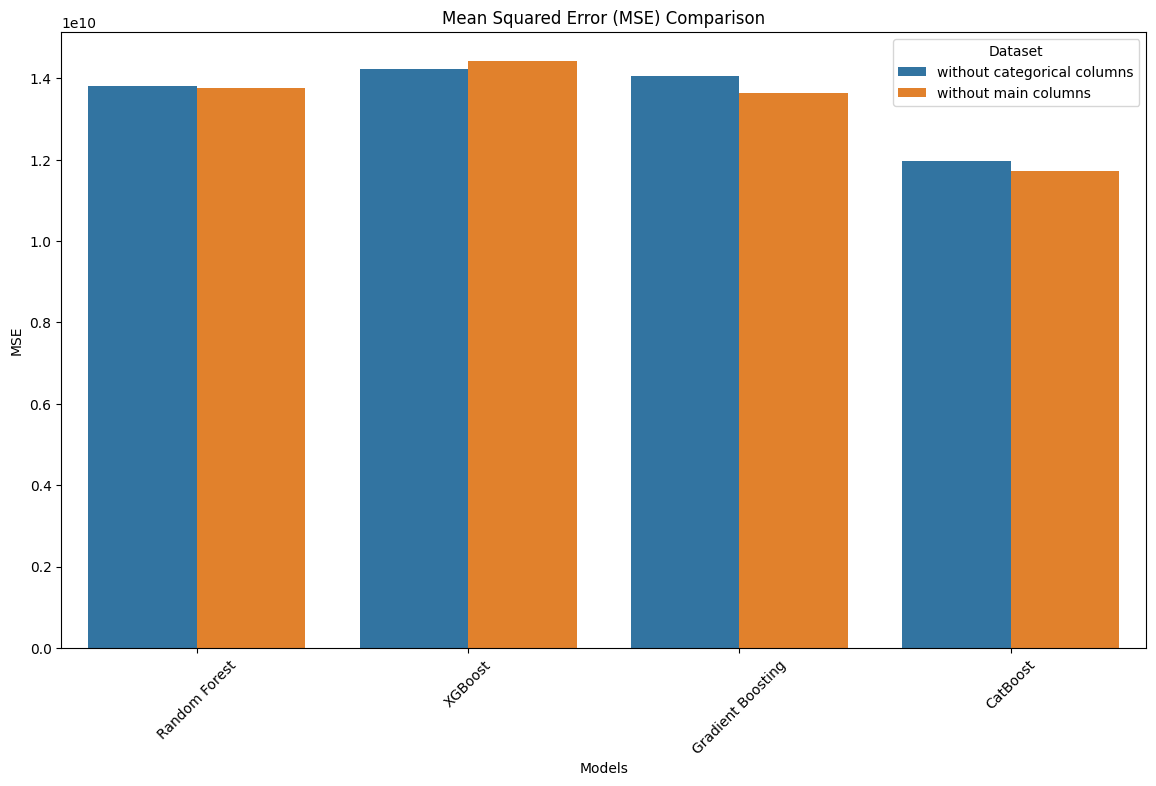

C:\Users\jos_m\AppData\Local\Temp\ipykernel_15900\1189315549.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='R2', hue='Dataset', data=results_df, ci=None)


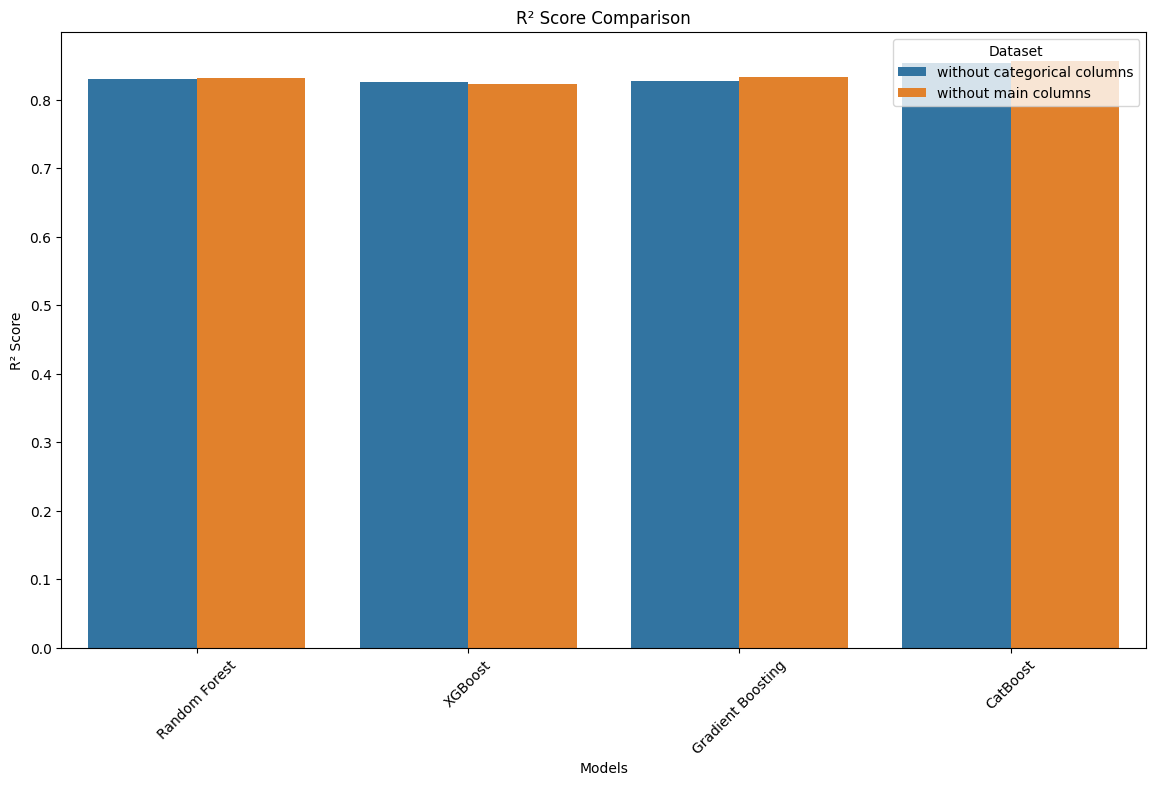

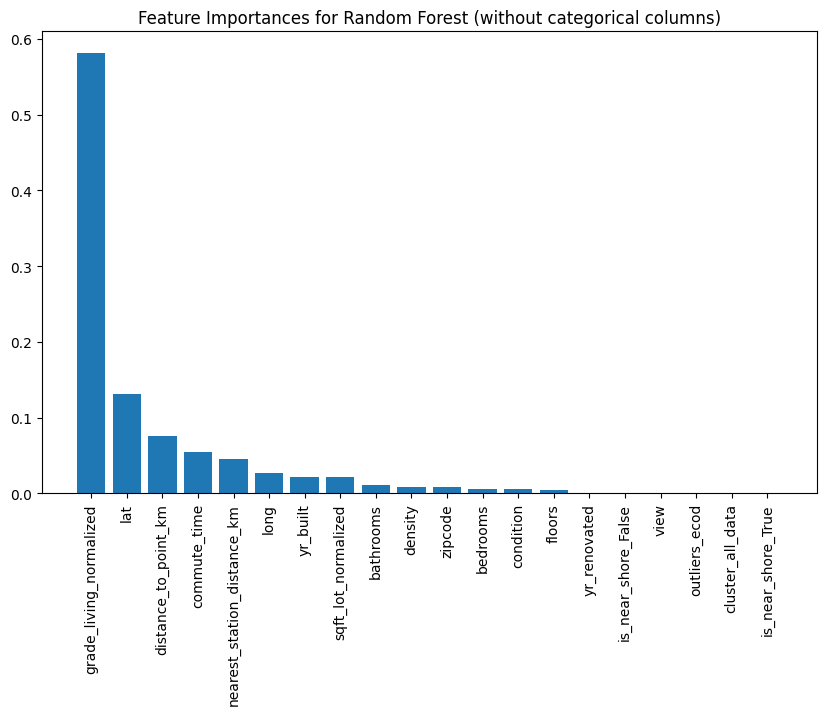

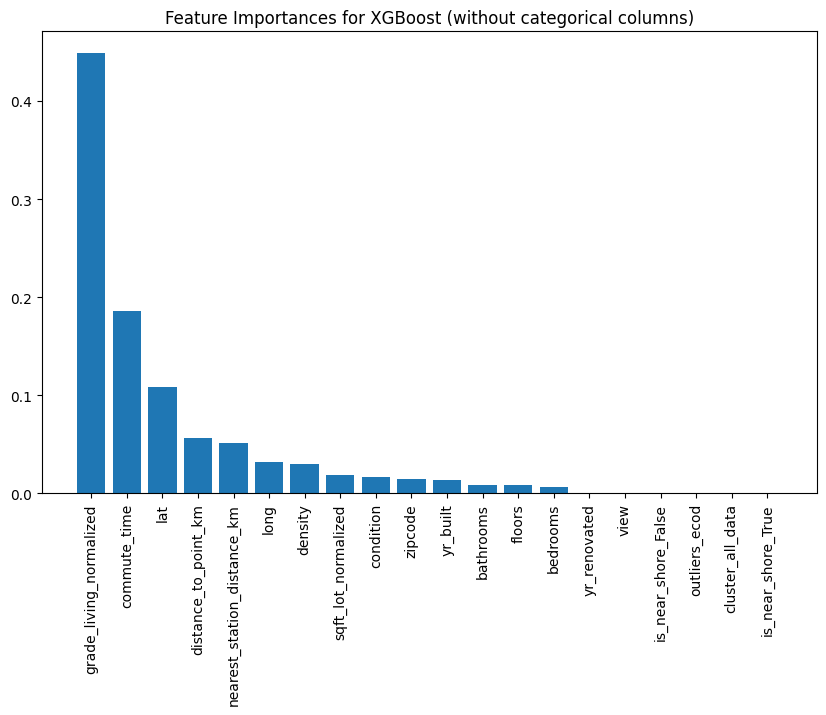

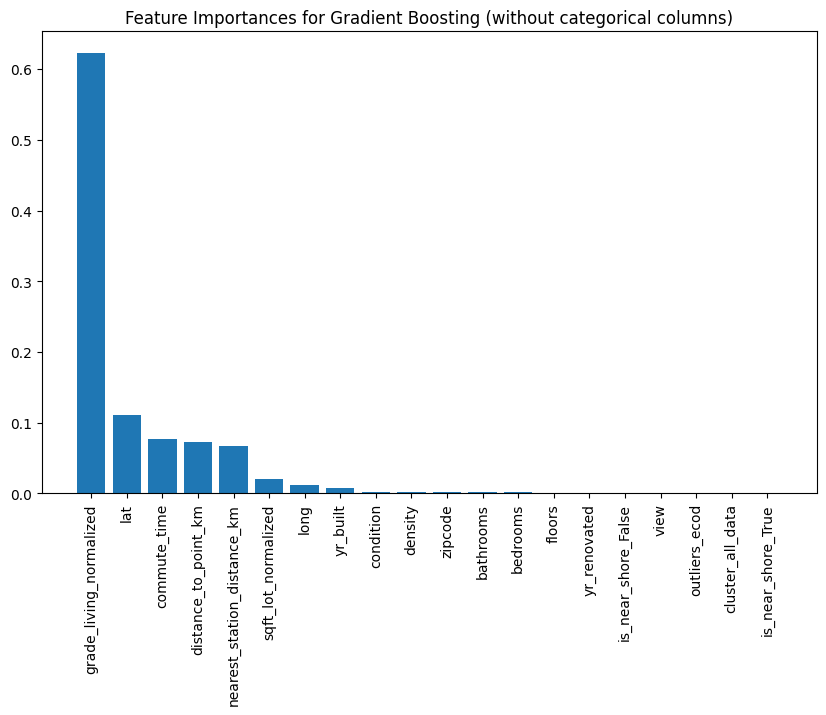

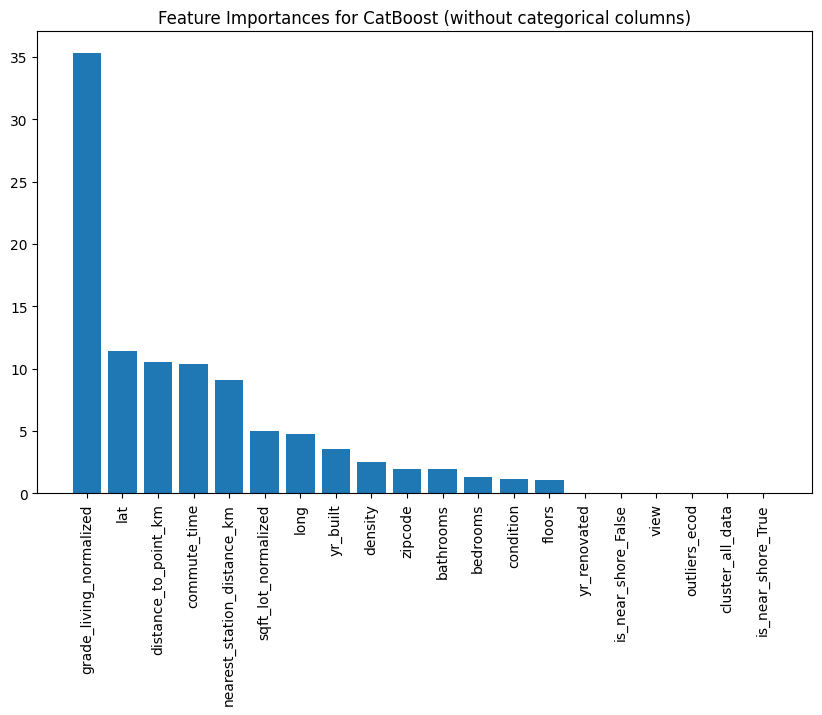

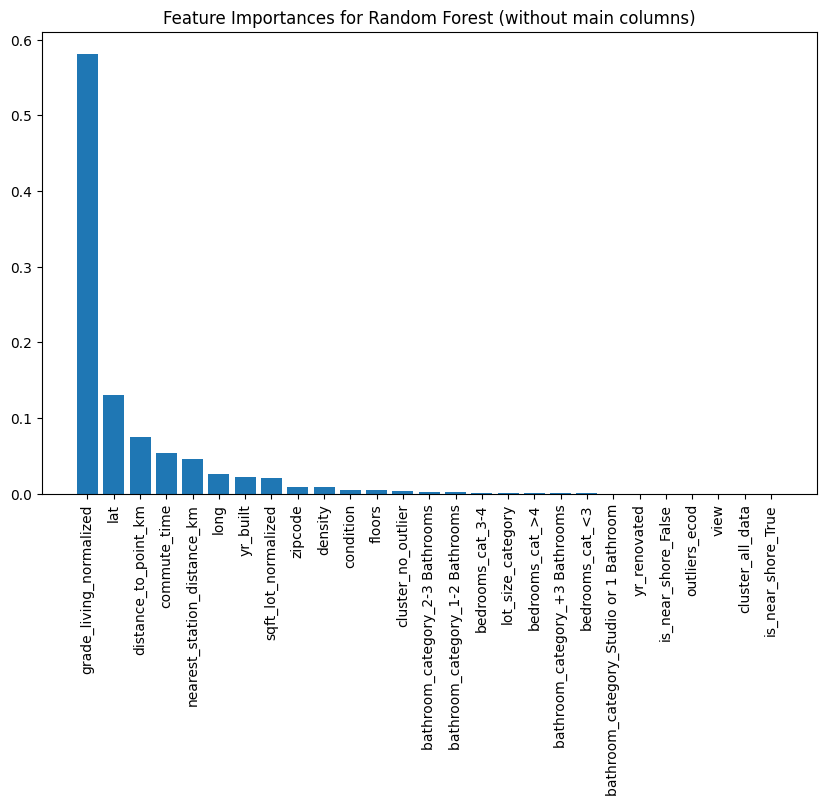

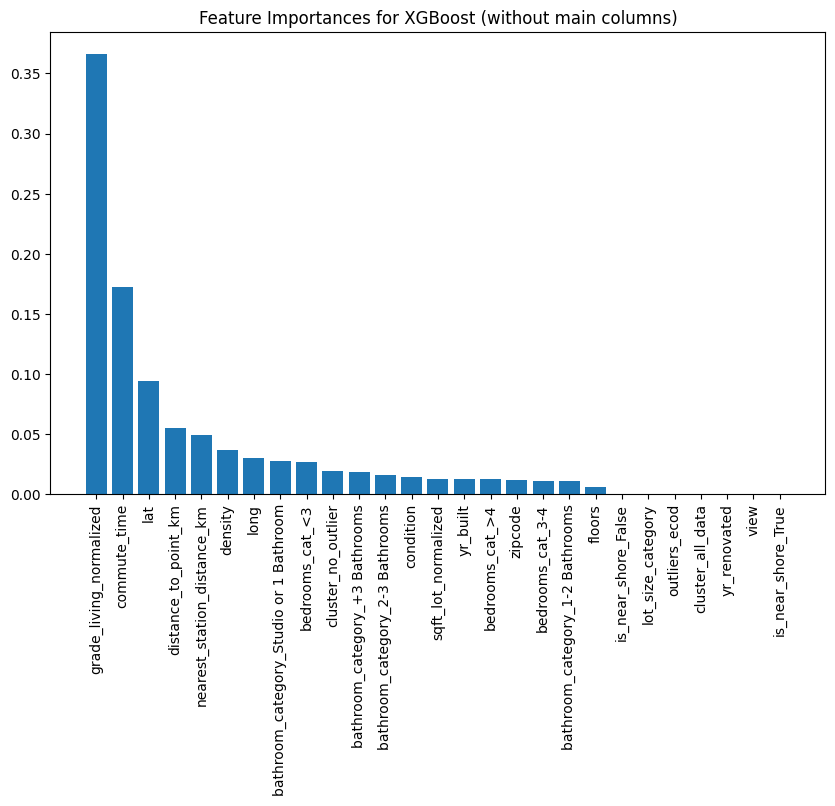

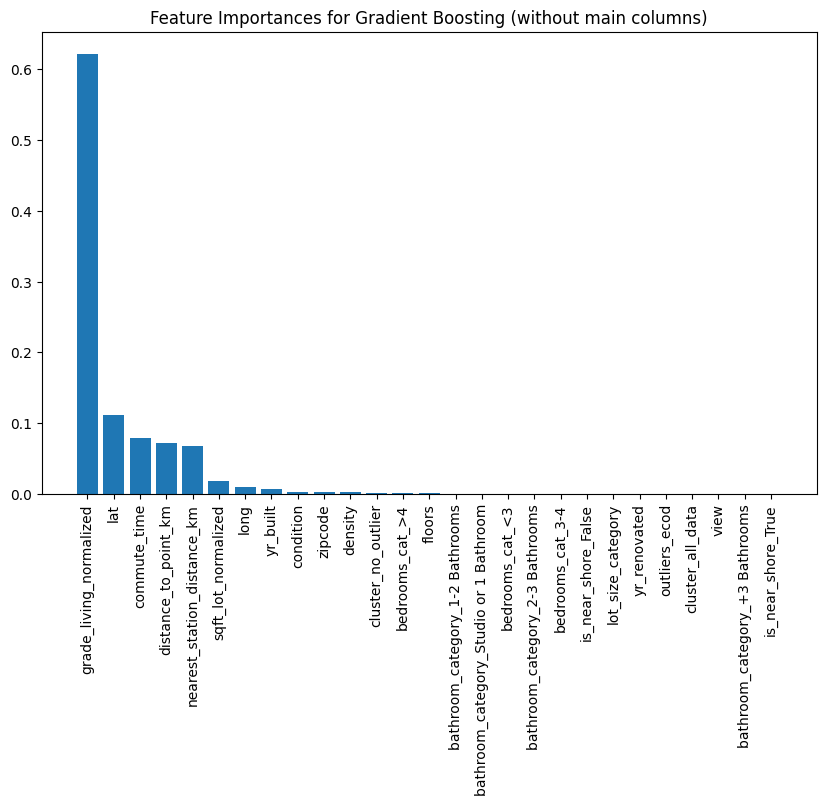

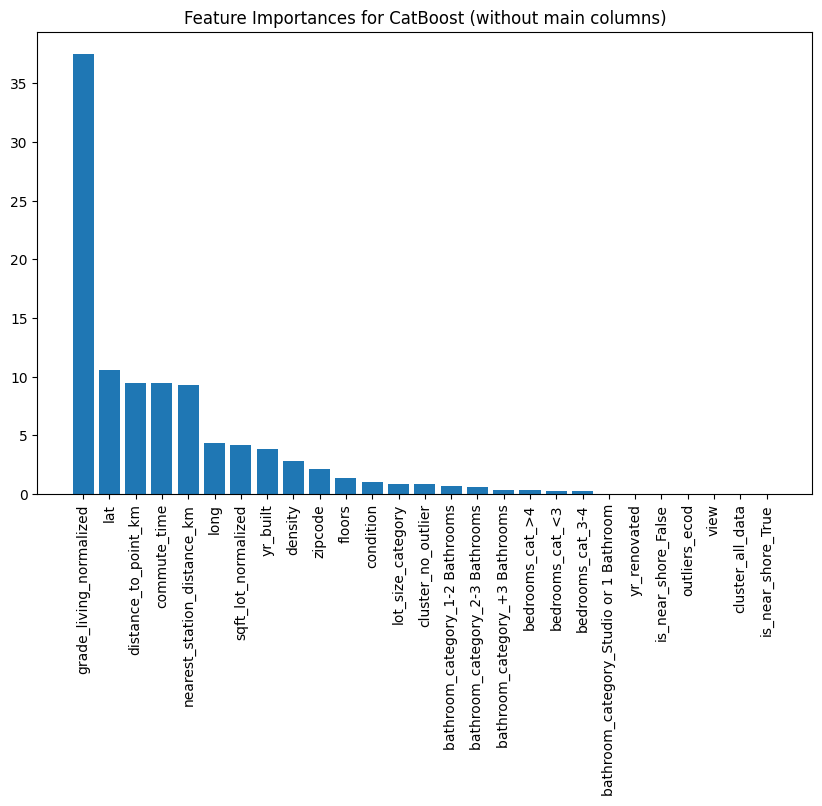

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Veriyi yükleme ve işleme (Önceki adımlar)
df = pd.read_csv('clustered_data_v2.csv')
categorical_columns = ['bathroom_category', 'bedrooms_cat', 'is_near_shore']
df = pd.get_dummies(df, columns=categorical_columns)

columns_to_drop_cat = [
    'lot_size_category', 'grade_living_category', 
    'bathroom_category_+3 Bathrooms', 'bathroom_category_1-2 Bathrooms',
    'bathroom_category_2-3 Bathrooms', 'bathroom_category_Studio or 1 Bathroom', 
    'bedrooms_cat_3-4', 'bedrooms_cat_<3', 'bedrooms_cat_>4','sqft_lot','grade_living','cluster_no_outlier','waterfront'
]

columns_to_drop_main = [
    'bedrooms', 'bathrooms','sqft_lot','grade_living','grade_living_category','waterfront'
]

df_wo_cat = df.drop(columns=columns_to_drop_cat)
df_wo_main = df.drop(columns=columns_to_drop_main)

# IQR Yöntemi ile Aykırı Değerleri Bulma ve Baskılamak
def cap_outliers(df):
    capped_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        capped_df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        capped_df[col] = np.where(df[col] > upper_bound, upper_bound, capped_df[col])
    return capped_df

df_wo_cat_capped = cap_outliers(df_wo_cat)
df_wo_main_capped = cap_outliers(df_wo_main)

# Feature importance ve model performansını hesaplama fonksiyonu
def evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
    }

    results = {}
    feature_importances = {}

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {"MSE": mse, "R2": r2}
        feature_importances[name] = model.feature_importances_

    return results, feature_importances, X.columns

# Değerlendirme ve feature importance hesaplama
y_wo_cat_capped = df_wo_cat_capped[df_wo_cat_capped['cluster_all_data'] == 2]['price']
X_wo_cat_capped = df_wo_cat_capped[df_wo_cat_capped['cluster_all_data'] == 2].drop('price', axis=1)

y_wo_main_capped =  df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2]['price']
X_wo_main_capped = df_wo_main_capped[df_wo_main_capped['cluster_all_data'] == 2].drop('price', axis=1)

results_wo_cat, feature_importances_wo_cat, feature_names_wo_cat = evaluate_models(X_wo_cat_capped, y_wo_cat_capped)
results_wo_main, feature_importances_wo_main, feature_names_wo_main = evaluate_models(X_wo_main_capped, y_wo_main_capped)

# Performans sonuçlarını yazdırma
print("Results for dataset without categorical columns:")
for model, metrics in results_wo_cat.items():
    print(f"{model} - MSE: {metrics['MSE']}, R2: {metrics['R2']}")

print("\nResults for dataset without main columns:")
for model, metrics in results_wo_main.items():
    print(f"{model} - MSE: {metrics['MSE']}, R2: {metrics['R2']}")

# Performans sonuçlarını bir DataFrame'e dönüştürme
results_df_cat = pd.DataFrame(results_wo_cat).T.reset_index().rename(columns={"index": "Model"})
results_df_cat['Dataset'] = 'without categorical columns'
results_df_main = pd.DataFrame(results_wo_main).T.reset_index().rename(columns={"index": "Model"})
results_df_main['Dataset'] = 'without main columns'
results_df = pd.concat([results_df_cat, results_df_main])

# MSE grafiği
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='MSE', hue='Dataset', data=results_df, ci=None)
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.show()

# R2 skorları grafiği
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='R2', hue='Dataset', data=results_df, ci=None)
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.show()

# Feature importances grafiği
def plot_feature_importances(feature_importances, feature_names, model_name, dataset_name):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
    plt.title(f"Feature Importances for {model_name} ({dataset_name})")
    plt.show()

# Grafiklerle karşılaştırma
for model_name in feature_importances_wo_cat.keys():
    plot_feature_importances(feature_importances_wo_cat[model_name], feature_names_wo_cat, model_name, "without categorical columns")

for model_name in feature_importances_wo_main.keys():
    plot_feature_importances(feature_importances_wo_main[model_name], feature_names_wo_main, model_name, "without main columns")


In [7]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# CatBoost için hiperparametre aralıkları
param_grid = {
    'iterations': [ 500,1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# GridSearchCV ile CatBoost modelini iyileştirme
catboost = CatBoostRegressor(verbose=0, random_state=42)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_wo_cat_capped, y_wo_cat_capped)

# En iyi parametreleri ve modeli bulma
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("En iyi parametreler:", best_params)

# En iyi model ile tahmin yapma ve değerlendirme
X_train, X_test, y_train, y_test = train_test_split(X_wo_cat_capped, y_wo_cat_capped, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"En iyi CatBoost modeli - MSE: {mse}, R2: {r2}")
# RMSE= 111.812

En iyi parametreler: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
En iyi CatBoost modeli - MSE: 12502133029.880785, R2: 0.8469725717437102


In [15]:
print('CatBoost :', np.sqrt(mse))

CatBoost : 111812.9376676992


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Random Forest için hiperparametre aralıkları
param_grid_rf = {
    'n_estimators': [300, 500,700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [8, 10, None],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# GridSearchCV ile Random Forest modelini iyileştirme
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_wo_cat_capped, y_wo_cat_capped)

# En iyi parametreleri ve modeli bulma
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print("En iyi Random Forest parametreleri:", best_params_rf)

# En iyi model ile tahmin yapma ve değerlendirme
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_wo_cat_capped, y_wo_cat_capped, test_size=0.2, random_state=42)
best_model_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = best_model_rf.predict(X_test_rf)

# RMSE hesaplama
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f"En iyi Random Forest modeli - RMSE: {rmse_rf}, R2: {r2_rf}")


c:\Users\jos_m\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
810 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
248 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jos_m\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jos_m\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\jos_m\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py

En iyi Random Forest parametreleri: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
En iyi Random Forest modeli - RMSE: 115279.05738990378, R2: 0.8373380413948595


In [16]:
X_wo_cat_capped.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot_normalized', 'floors', 'view',
       'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'nearest_station_distance_km', 'density', 'commute_time',
       'distance_to_point_km', 'grade_living_normalized', 'outliers_ecod',
       'cluster_all_data', 'is_near_shore_False', 'is_near_shore_True'],
      dtype='object')

In [ ]:
print(f"En iyi Random Forest modeli - RMSE: {rmse_rf}, R2: {r2_rf}")
print('Random Forest RMSE :', np.sqrt(mse))

(2104, 20)